# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

#mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
#pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

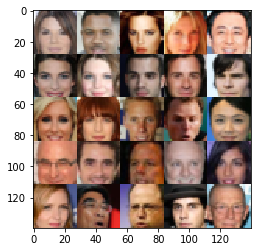

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_r = tf.placeholder(tf.float32, name='learning_r')
    return inputs_real, inputs_z, learning_r


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.2
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=False if is_train==True else True):#reuse= not is_train):
        alpha=0.2
        # First fully connected layer
        dim1=7
        x1 = tf.layers.dense(z, dim1*dim1*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, dim1, dim1, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now

        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape [2], data_shape[3], z_dim)
    
    d_loss, g_loss=  model_loss(inputs_real, inputs_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    # TODO: Build Model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2
                #Sample noise
                batch_z = np.random.uniform(-1,1,size=(batch_size, z_dim))
                
                #Run opt
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr: learning_rate})
                
                if (steps %10 == 0) :
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if ((steps % 100) == 0) :
                    show_generator_output(sess, show_n_images, inputs_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 8.9768... Generator Loss: 0.0004
Epoch 1/2... Discriminator Loss: 0.2217... Generator Loss: 2.5119
Epoch 1/2... Discriminator Loss: 8.2448... Generator Loss: 0.0012
Epoch 1/2... Discriminator Loss: 1.8383... Generator Loss: 2.6081
Epoch 1/2... Discriminator Loss: 1.6002... Generator Loss: 1.5631
Epoch 1/2... Discriminator Loss: 1.4775... Generator Loss: 0.8302
Epoch 1/2... Discriminator Loss: 1.4526... Generator Loss: 0.9101
Epoch 1/2... Discriminator Loss: 1.4140... Generator Loss: 0.9860
Epoch 1/2... Discriminator Loss: 1.8050... Generator Loss: 1.2704
Epoch 1/2... Discriminator Loss: 1.3165... Generator Loss: 0.7619


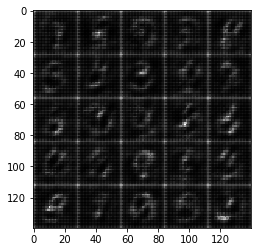

Epoch 1/2... Discriminator Loss: 1.2726... Generator Loss: 0.9968
Epoch 1/2... Discriminator Loss: 1.6384... Generator Loss: 1.2628
Epoch 1/2... Discriminator Loss: 1.4479... Generator Loss: 0.4571
Epoch 1/2... Discriminator Loss: 1.8298... Generator Loss: 0.2226
Epoch 1/2... Discriminator Loss: 1.5420... Generator Loss: 0.3350
Epoch 1/2... Discriminator Loss: 1.0891... Generator Loss: 0.6918
Epoch 1/2... Discriminator Loss: 1.2898... Generator Loss: 0.7108
Epoch 1/2... Discriminator Loss: 1.3499... Generator Loss: 1.1028
Epoch 1/2... Discriminator Loss: 1.3687... Generator Loss: 1.2461
Epoch 1/2... Discriminator Loss: 1.3219... Generator Loss: 0.6949


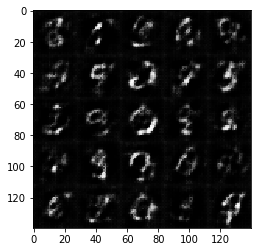

Epoch 1/2... Discriminator Loss: 1.6124... Generator Loss: 1.9372
Epoch 1/2... Discriminator Loss: 1.1395... Generator Loss: 0.7960
Epoch 1/2... Discriminator Loss: 1.1796... Generator Loss: 1.1791
Epoch 1/2... Discriminator Loss: 1.6792... Generator Loss: 0.2755
Epoch 1/2... Discriminator Loss: 1.7610... Generator Loss: 0.2323
Epoch 1/2... Discriminator Loss: 1.5977... Generator Loss: 0.2833
Epoch 1/2... Discriminator Loss: 1.1205... Generator Loss: 1.7553
Epoch 1/2... Discriminator Loss: 1.2023... Generator Loss: 0.6796
Epoch 1/2... Discriminator Loss: 1.2098... Generator Loss: 0.4923
Epoch 1/2... Discriminator Loss: 1.2368... Generator Loss: 0.4564


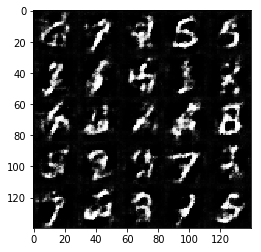

Epoch 1/2... Discriminator Loss: 1.1286... Generator Loss: 0.7979
Epoch 1/2... Discriminator Loss: 1.1485... Generator Loss: 1.3370
Epoch 1/2... Discriminator Loss: 1.3029... Generator Loss: 1.0637
Epoch 1/2... Discriminator Loss: 1.9115... Generator Loss: 0.2278
Epoch 1/2... Discriminator Loss: 1.6142... Generator Loss: 0.2873
Epoch 1/2... Discriminator Loss: 1.1896... Generator Loss: 0.8485
Epoch 1/2... Discriminator Loss: 1.9336... Generator Loss: 0.1933
Epoch 1/2... Discriminator Loss: 1.2938... Generator Loss: 2.6272
Epoch 1/2... Discriminator Loss: 1.1368... Generator Loss: 0.6590
Epoch 1/2... Discriminator Loss: 1.3007... Generator Loss: 1.2661


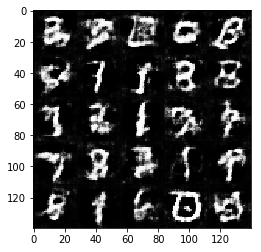

Epoch 1/2... Discriminator Loss: 1.6186... Generator Loss: 0.2925
Epoch 1/2... Discriminator Loss: 1.1731... Generator Loss: 0.8480
Epoch 1/2... Discriminator Loss: 1.5975... Generator Loss: 0.2858
Epoch 1/2... Discriminator Loss: 1.0603... Generator Loss: 1.3661
Epoch 1/2... Discriminator Loss: 1.1307... Generator Loss: 0.9584
Epoch 1/2... Discriminator Loss: 1.2956... Generator Loss: 1.6051
Epoch 1/2... Discriminator Loss: 1.2846... Generator Loss: 1.3617
Epoch 1/2... Discriminator Loss: 0.9733... Generator Loss: 1.4767
Epoch 1/2... Discriminator Loss: 2.0354... Generator Loss: 0.1726
Epoch 1/2... Discriminator Loss: 1.1424... Generator Loss: 1.2452


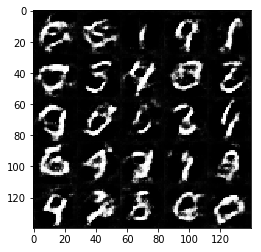

Epoch 1/2... Discriminator Loss: 1.4360... Generator Loss: 0.3817
Epoch 1/2... Discriminator Loss: 1.5650... Generator Loss: 0.3208
Epoch 1/2... Discriminator Loss: 1.7388... Generator Loss: 0.2488
Epoch 1/2... Discriminator Loss: 1.4624... Generator Loss: 0.3539
Epoch 1/2... Discriminator Loss: 1.7139... Generator Loss: 0.2538
Epoch 1/2... Discriminator Loss: 1.1536... Generator Loss: 1.0399
Epoch 1/2... Discriminator Loss: 1.6863... Generator Loss: 0.2585
Epoch 1/2... Discriminator Loss: 1.4884... Generator Loss: 0.3089
Epoch 1/2... Discriminator Loss: 1.5762... Generator Loss: 0.3295
Epoch 1/2... Discriminator Loss: 1.1168... Generator Loss: 1.3140


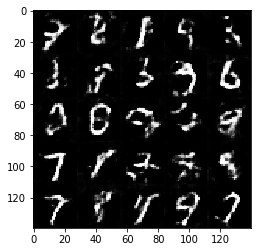

Epoch 1/2... Discriminator Loss: 1.7344... Generator Loss: 0.2484
Epoch 1/2... Discriminator Loss: 0.8973... Generator Loss: 1.2085
Epoch 1/2... Discriminator Loss: 1.0695... Generator Loss: 0.7758
Epoch 1/2... Discriminator Loss: 1.4120... Generator Loss: 1.2831
Epoch 1/2... Discriminator Loss: 1.4094... Generator Loss: 0.3941
Epoch 1/2... Discriminator Loss: 0.9449... Generator Loss: 0.8851
Epoch 1/2... Discriminator Loss: 1.6416... Generator Loss: 0.2736
Epoch 1/2... Discriminator Loss: 1.5215... Generator Loss: 0.3190
Epoch 1/2... Discriminator Loss: 1.1794... Generator Loss: 1.1036
Epoch 1/2... Discriminator Loss: 0.8190... Generator Loss: 1.2209


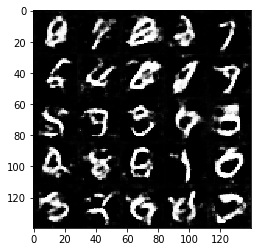

Epoch 1/2... Discriminator Loss: 1.1618... Generator Loss: 0.5591
Epoch 1/2... Discriminator Loss: 2.3529... Generator Loss: 0.1443
Epoch 1/2... Discriminator Loss: 1.4145... Generator Loss: 0.3695
Epoch 1/2... Discriminator Loss: 1.1243... Generator Loss: 0.6527
Epoch 1/2... Discriminator Loss: 0.9927... Generator Loss: 0.8018
Epoch 1/2... Discriminator Loss: 1.0539... Generator Loss: 0.9473
Epoch 1/2... Discriminator Loss: 1.5439... Generator Loss: 2.2182
Epoch 1/2... Discriminator Loss: 1.1397... Generator Loss: 0.5804
Epoch 1/2... Discriminator Loss: 1.0383... Generator Loss: 0.6235
Epoch 1/2... Discriminator Loss: 1.2576... Generator Loss: 2.1636


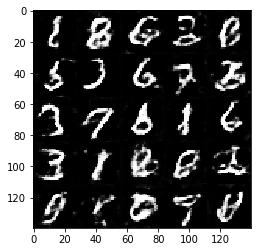

Epoch 1/2... Discriminator Loss: 1.8903... Generator Loss: 0.2086
Epoch 1/2... Discriminator Loss: 1.2583... Generator Loss: 0.4632
Epoch 1/2... Discriminator Loss: 1.9278... Generator Loss: 0.2477
Epoch 1/2... Discriminator Loss: 2.0635... Generator Loss: 0.1735
Epoch 1/2... Discriminator Loss: 1.0216... Generator Loss: 0.7967
Epoch 1/2... Discriminator Loss: 1.3155... Generator Loss: 0.4149
Epoch 1/2... Discriminator Loss: 1.4442... Generator Loss: 0.3312
Epoch 1/2... Discriminator Loss: 0.6992... Generator Loss: 0.9916
Epoch 1/2... Discriminator Loss: 1.2180... Generator Loss: 0.8078
Epoch 1/2... Discriminator Loss: 1.2107... Generator Loss: 1.7522


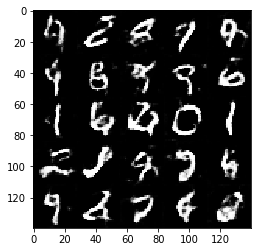

Epoch 1/2... Discriminator Loss: 0.7581... Generator Loss: 1.2010
Epoch 1/2... Discriminator Loss: 0.8829... Generator Loss: 0.7724
Epoch 1/2... Discriminator Loss: 1.5159... Generator Loss: 0.3174
Epoch 1/2... Discriminator Loss: 1.2832... Generator Loss: 0.4810
Epoch 1/2... Discriminator Loss: 0.8890... Generator Loss: 0.8595
Epoch 1/2... Discriminator Loss: 1.2778... Generator Loss: 0.4287
Epoch 1/2... Discriminator Loss: 0.7382... Generator Loss: 1.0251
Epoch 1/2... Discriminator Loss: 1.1266... Generator Loss: 0.5572
Epoch 1/2... Discriminator Loss: 1.3581... Generator Loss: 0.5904
Epoch 1/2... Discriminator Loss: 1.3301... Generator Loss: 1.5718


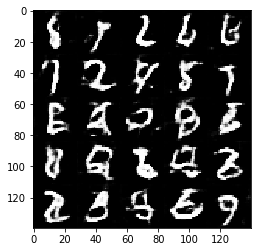

Epoch 1/2... Discriminator Loss: 1.0702... Generator Loss: 0.7416
Epoch 1/2... Discriminator Loss: 0.9810... Generator Loss: 0.7900
Epoch 1/2... Discriminator Loss: 0.7692... Generator Loss: 0.9383
Epoch 1/2... Discriminator Loss: 0.9266... Generator Loss: 0.7137
Epoch 1/2... Discriminator Loss: 0.9224... Generator Loss: 1.0885
Epoch 1/2... Discriminator Loss: 0.8652... Generator Loss: 2.0526
Epoch 1/2... Discriminator Loss: 0.7762... Generator Loss: 1.1334
Epoch 1/2... Discriminator Loss: 1.4011... Generator Loss: 0.3952
Epoch 1/2... Discriminator Loss: 1.0577... Generator Loss: 0.5154
Epoch 1/2... Discriminator Loss: 1.0939... Generator Loss: 0.6993


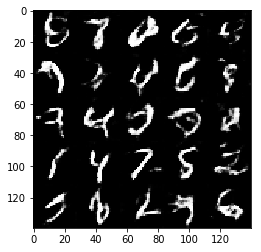

Epoch 1/2... Discriminator Loss: 0.8144... Generator Loss: 1.6613
Epoch 1/2... Discriminator Loss: 1.1885... Generator Loss: 0.4976
Epoch 1/2... Discriminator Loss: 0.5511... Generator Loss: 1.2516
Epoch 1/2... Discriminator Loss: 0.9700... Generator Loss: 2.0997
Epoch 1/2... Discriminator Loss: 0.8283... Generator Loss: 0.8381
Epoch 1/2... Discriminator Loss: 0.8695... Generator Loss: 1.6727
Epoch 1/2... Discriminator Loss: 2.0614... Generator Loss: 0.1629
Epoch 1/2... Discriminator Loss: 2.1764... Generator Loss: 0.1723
Epoch 1/2... Discriminator Loss: 0.7098... Generator Loss: 1.4619
Epoch 1/2... Discriminator Loss: 1.3515... Generator Loss: 2.7139


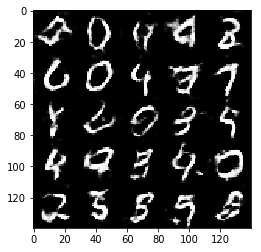

Epoch 1/2... Discriminator Loss: 0.5615... Generator Loss: 1.2350
Epoch 1/2... Discriminator Loss: 0.7943... Generator Loss: 0.8713
Epoch 1/2... Discriminator Loss: 0.5395... Generator Loss: 1.3142
Epoch 1/2... Discriminator Loss: 1.0634... Generator Loss: 0.9961
Epoch 1/2... Discriminator Loss: 0.9566... Generator Loss: 0.7487
Epoch 1/2... Discriminator Loss: 1.0256... Generator Loss: 0.6122
Epoch 1/2... Discriminator Loss: 1.1201... Generator Loss: 0.9436
Epoch 1/2... Discriminator Loss: 1.0026... Generator Loss: 0.8485
Epoch 1/2... Discriminator Loss: 0.6084... Generator Loss: 1.3582
Epoch 1/2... Discriminator Loss: 0.8370... Generator Loss: 0.7675


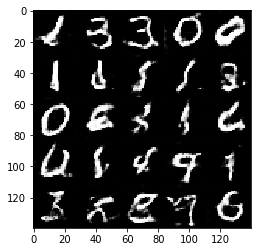

Epoch 1/2... Discriminator Loss: 0.9972... Generator Loss: 0.6219
Epoch 1/2... Discriminator Loss: 2.3905... Generator Loss: 4.0526
Epoch 1/2... Discriminator Loss: 1.5855... Generator Loss: 0.3812
Epoch 1/2... Discriminator Loss: 0.9773... Generator Loss: 0.6391
Epoch 1/2... Discriminator Loss: 1.0085... Generator Loss: 0.6171
Epoch 1/2... Discriminator Loss: 0.5436... Generator Loss: 1.1542
Epoch 1/2... Discriminator Loss: 0.4358... Generator Loss: 1.2935
Epoch 1/2... Discriminator Loss: 2.1812... Generator Loss: 0.2611
Epoch 1/2... Discriminator Loss: 1.4835... Generator Loss: 0.3624
Epoch 1/2... Discriminator Loss: 1.6016... Generator Loss: 0.3278


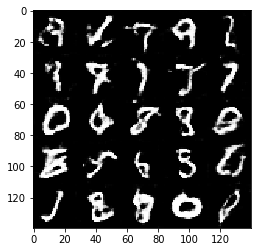

Epoch 1/2... Discriminator Loss: 1.2126... Generator Loss: 0.5292
Epoch 1/2... Discriminator Loss: 2.7116... Generator Loss: 0.1209
Epoch 1/2... Discriminator Loss: 1.3282... Generator Loss: 0.4272
Epoch 1/2... Discriminator Loss: 0.8834... Generator Loss: 0.7461
Epoch 1/2... Discriminator Loss: 0.5297... Generator Loss: 1.0918
Epoch 1/2... Discriminator Loss: 0.2783... Generator Loss: 1.8180
Epoch 1/2... Discriminator Loss: 0.3792... Generator Loss: 1.4095
Epoch 1/2... Discriminator Loss: 2.4365... Generator Loss: 4.0181
Epoch 1/2... Discriminator Loss: 1.0758... Generator Loss: 0.5409
Epoch 1/2... Discriminator Loss: 1.5875... Generator Loss: 0.3099


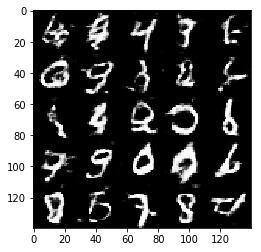

Epoch 1/2... Discriminator Loss: 0.7059... Generator Loss: 1.4736
Epoch 1/2... Discriminator Loss: 0.9334... Generator Loss: 0.7482
Epoch 1/2... Discriminator Loss: 0.9200... Generator Loss: 0.6817
Epoch 1/2... Discriminator Loss: 0.6415... Generator Loss: 0.9901
Epoch 1/2... Discriminator Loss: 0.9640... Generator Loss: 2.7535
Epoch 1/2... Discriminator Loss: 0.9910... Generator Loss: 1.6622
Epoch 1/2... Discriminator Loss: 0.9586... Generator Loss: 0.6996
Epoch 1/2... Discriminator Loss: 0.8624... Generator Loss: 0.7528
Epoch 1/2... Discriminator Loss: 1.1080... Generator Loss: 0.5936
Epoch 1/2... Discriminator Loss: 0.6332... Generator Loss: 1.1242


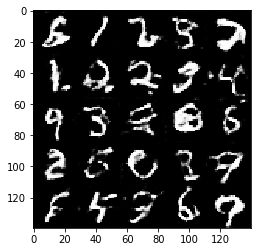

Epoch 1/2... Discriminator Loss: 0.5197... Generator Loss: 1.2354
Epoch 1/2... Discriminator Loss: 0.8048... Generator Loss: 0.7967
Epoch 1/2... Discriminator Loss: 1.1708... Generator Loss: 0.5041
Epoch 1/2... Discriminator Loss: 0.5617... Generator Loss: 1.1492
Epoch 1/2... Discriminator Loss: 2.0724... Generator Loss: 0.2099
Epoch 1/2... Discriminator Loss: 0.5068... Generator Loss: 2.8747
Epoch 1/2... Discriminator Loss: 0.8831... Generator Loss: 0.6801
Epoch 1/2... Discriminator Loss: 0.3118... Generator Loss: 1.6264
Epoch 1/2... Discriminator Loss: 0.9429... Generator Loss: 1.1070
Epoch 1/2... Discriminator Loss: 1.1959... Generator Loss: 0.4743


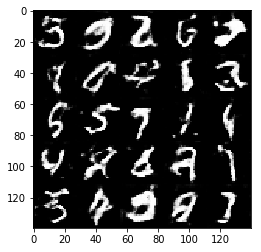

Epoch 1/2... Discriminator Loss: 1.5528... Generator Loss: 0.3809
Epoch 1/2... Discriminator Loss: 0.9250... Generator Loss: 0.8079
Epoch 1/2... Discriminator Loss: 0.5590... Generator Loss: 1.1637
Epoch 1/2... Discriminator Loss: 0.9815... Generator Loss: 0.7016
Epoch 1/2... Discriminator Loss: 0.8041... Generator Loss: 1.5322
Epoch 1/2... Discriminator Loss: 1.2144... Generator Loss: 0.5081
Epoch 1/2... Discriminator Loss: 0.6029... Generator Loss: 1.0214
Epoch 1/2... Discriminator Loss: 0.8595... Generator Loss: 0.7810
Epoch 1/2... Discriminator Loss: 1.3441... Generator Loss: 0.4811
Epoch 1/2... Discriminator Loss: 1.0579... Generator Loss: 0.6040


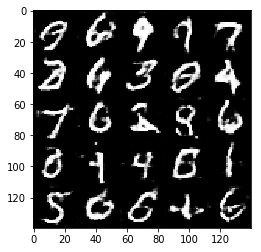

Epoch 1/2... Discriminator Loss: 0.6550... Generator Loss: 0.9330
Epoch 1/2... Discriminator Loss: 1.0859... Generator Loss: 2.3492
Epoch 1/2... Discriminator Loss: 0.5990... Generator Loss: 1.0701
Epoch 1/2... Discriminator Loss: 0.7546... Generator Loss: 0.8763
Epoch 1/2... Discriminator Loss: 0.6769... Generator Loss: 0.9417
Epoch 1/2... Discriminator Loss: 0.3785... Generator Loss: 1.4614
Epoch 1/2... Discriminator Loss: 1.1813... Generator Loss: 2.5564
Epoch 2/2... Discriminator Loss: 0.6978... Generator Loss: 1.7970
Epoch 2/2... Discriminator Loss: 2.3042... Generator Loss: 0.1739
Epoch 2/2... Discriminator Loss: 0.5770... Generator Loss: 1.1364
Epoch 2/2... Discriminator Loss: 0.6968... Generator Loss: 0.9479
Epoch 2/2... Discriminator Loss: 0.6366... Generator Loss: 1.0170
Epoch 2/2... Discriminator Loss: 0.4761... Generator Loss: 1.3940
Epoch 2/2... Discriminator Loss: 0.6960... Generator Loss: 0.9686
Epoch 2/2... Discriminator Loss: 1.0135... Generator Loss: 2.9163
Epoch 2/2.

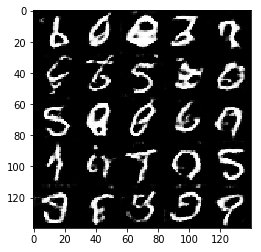

Epoch 2/2... Discriminator Loss: 0.4093... Generator Loss: 1.5203
Epoch 2/2... Discriminator Loss: 0.3298... Generator Loss: 1.6164
Epoch 2/2... Discriminator Loss: 0.3470... Generator Loss: 1.7831
Epoch 2/2... Discriminator Loss: 2.0267... Generator Loss: 0.2965
Epoch 2/2... Discriminator Loss: 0.8604... Generator Loss: 0.7174
Epoch 2/2... Discriminator Loss: 0.6879... Generator Loss: 1.9858
Epoch 2/2... Discriminator Loss: 0.3884... Generator Loss: 1.7757
Epoch 2/2... Discriminator Loss: 0.3656... Generator Loss: 1.5355
Epoch 2/2... Discriminator Loss: 0.4983... Generator Loss: 1.3873
Epoch 2/2... Discriminator Loss: 0.7671... Generator Loss: 0.8445


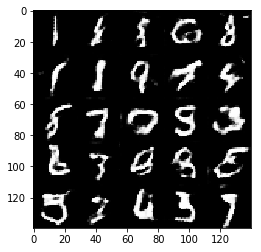

Epoch 2/2... Discriminator Loss: 0.1741... Generator Loss: 2.3331
Epoch 2/2... Discriminator Loss: 0.2462... Generator Loss: 1.8452
Epoch 2/2... Discriminator Loss: 0.7417... Generator Loss: 0.9626
Epoch 2/2... Discriminator Loss: 0.5061... Generator Loss: 1.3356
Epoch 2/2... Discriminator Loss: 0.7507... Generator Loss: 0.9213
Epoch 2/2... Discriminator Loss: 0.2133... Generator Loss: 2.2105
Epoch 2/2... Discriminator Loss: 1.9377... Generator Loss: 0.2915
Epoch 2/2... Discriminator Loss: 0.8907... Generator Loss: 0.8063
Epoch 2/2... Discriminator Loss: 0.3743... Generator Loss: 1.6596
Epoch 2/2... Discriminator Loss: 0.6385... Generator Loss: 0.9745


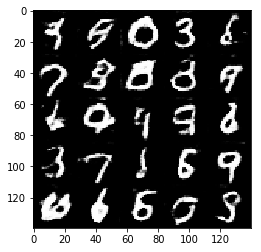

Epoch 2/2... Discriminator Loss: 0.6301... Generator Loss: 1.0655
Epoch 2/2... Discriminator Loss: 0.4517... Generator Loss: 1.3549
Epoch 2/2... Discriminator Loss: 0.5180... Generator Loss: 1.4825
Epoch 2/2... Discriminator Loss: 2.3437... Generator Loss: 0.1439
Epoch 2/2... Discriminator Loss: 0.9070... Generator Loss: 0.6951
Epoch 2/2... Discriminator Loss: 1.2139... Generator Loss: 3.1315
Epoch 2/2... Discriminator Loss: 0.6445... Generator Loss: 1.0082
Epoch 2/2... Discriminator Loss: 0.5138... Generator Loss: 1.3125
Epoch 2/2... Discriminator Loss: 0.3361... Generator Loss: 1.7510
Epoch 2/2... Discriminator Loss: 0.5006... Generator Loss: 1.3354


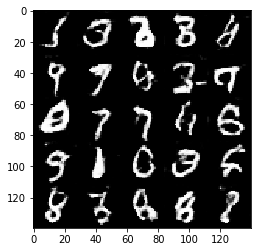

Epoch 2/2... Discriminator Loss: 1.4051... Generator Loss: 0.4498
Epoch 2/2... Discriminator Loss: 0.7228... Generator Loss: 1.2748
Epoch 2/2... Discriminator Loss: 0.6336... Generator Loss: 1.3399
Epoch 2/2... Discriminator Loss: 0.6763... Generator Loss: 1.0393
Epoch 2/2... Discriminator Loss: 0.4825... Generator Loss: 2.0596
Epoch 2/2... Discriminator Loss: 0.5101... Generator Loss: 1.3363
Epoch 2/2... Discriminator Loss: 0.4323... Generator Loss: 1.4721
Epoch 2/2... Discriminator Loss: 0.8340... Generator Loss: 1.9710
Epoch 2/2... Discriminator Loss: 0.9601... Generator Loss: 0.6933
Epoch 2/2... Discriminator Loss: 0.5231... Generator Loss: 1.2210


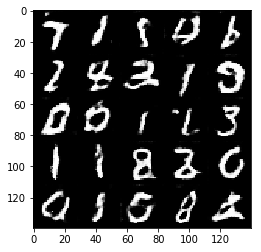

Epoch 2/2... Discriminator Loss: 0.1409... Generator Loss: 2.6301
Epoch 2/2... Discriminator Loss: 0.5014... Generator Loss: 1.2353
Epoch 2/2... Discriminator Loss: 0.3250... Generator Loss: 1.6923
Epoch 2/2... Discriminator Loss: 0.3735... Generator Loss: 1.5360
Epoch 2/2... Discriminator Loss: 2.0529... Generator Loss: 0.2464
Epoch 2/2... Discriminator Loss: 1.0292... Generator Loss: 0.5831
Epoch 2/2... Discriminator Loss: 1.2944... Generator Loss: 0.4216
Epoch 2/2... Discriminator Loss: 2.3206... Generator Loss: 4.1640
Epoch 2/2... Discriminator Loss: 0.6118... Generator Loss: 1.0949
Epoch 2/2... Discriminator Loss: 1.0051... Generator Loss: 0.6057


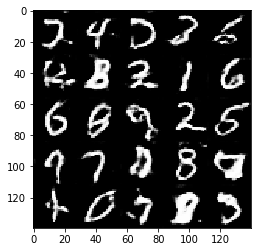

Epoch 2/2... Discriminator Loss: 0.7004... Generator Loss: 1.6840
Epoch 2/2... Discriminator Loss: 0.5097... Generator Loss: 1.1283
Epoch 2/2... Discriminator Loss: 0.2354... Generator Loss: 2.2614
Epoch 2/2... Discriminator Loss: 0.8446... Generator Loss: 0.8455
Epoch 2/2... Discriminator Loss: 0.8549... Generator Loss: 0.9307
Epoch 2/2... Discriminator Loss: 0.2618... Generator Loss: 1.8871
Epoch 2/2... Discriminator Loss: 1.0150... Generator Loss: 0.7203
Epoch 2/2... Discriminator Loss: 1.2728... Generator Loss: 0.5052
Epoch 2/2... Discriminator Loss: 1.6952... Generator Loss: 0.3351
Epoch 2/2... Discriminator Loss: 0.3886... Generator Loss: 1.5916


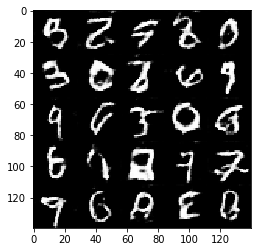

Epoch 2/2... Discriminator Loss: 1.7143... Generator Loss: 0.4117
Epoch 2/2... Discriminator Loss: 3.2714... Generator Loss: 0.0858
Epoch 2/2... Discriminator Loss: 0.6442... Generator Loss: 1.1013
Epoch 2/2... Discriminator Loss: 0.5026... Generator Loss: 1.3537
Epoch 2/2... Discriminator Loss: 0.7411... Generator Loss: 1.2569
Epoch 2/2... Discriminator Loss: 0.6188... Generator Loss: 1.1049
Epoch 2/2... Discriminator Loss: 0.9395... Generator Loss: 0.6983
Epoch 2/2... Discriminator Loss: 0.4729... Generator Loss: 1.3726
Epoch 2/2... Discriminator Loss: 2.0207... Generator Loss: 0.3220
Epoch 2/2... Discriminator Loss: 0.5113... Generator Loss: 1.2759


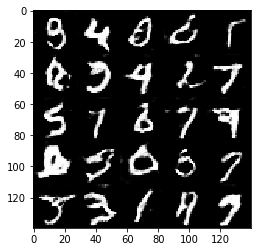

Epoch 2/2... Discriminator Loss: 2.0312... Generator Loss: 0.2991
Epoch 2/2... Discriminator Loss: 0.6426... Generator Loss: 1.0439
Epoch 2/2... Discriminator Loss: 1.3798... Generator Loss: 0.5056
Epoch 2/2... Discriminator Loss: 1.0553... Generator Loss: 0.6636
Epoch 2/2... Discriminator Loss: 0.3966... Generator Loss: 1.5653
Epoch 2/2... Discriminator Loss: 0.5701... Generator Loss: 1.3563
Epoch 2/2... Discriminator Loss: 0.7338... Generator Loss: 1.1347
Epoch 2/2... Discriminator Loss: 0.9134... Generator Loss: 0.8588
Epoch 2/2... Discriminator Loss: 1.6760... Generator Loss: 0.3211
Epoch 2/2... Discriminator Loss: 0.7718... Generator Loss: 0.8977


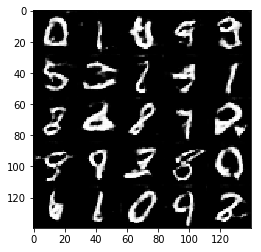

Epoch 2/2... Discriminator Loss: 0.4015... Generator Loss: 1.9974
Epoch 2/2... Discriminator Loss: 1.5174... Generator Loss: 0.4193
Epoch 2/2... Discriminator Loss: 1.0120... Generator Loss: 0.6797
Epoch 2/2... Discriminator Loss: 0.5070... Generator Loss: 1.2001
Epoch 2/2... Discriminator Loss: 0.5941... Generator Loss: 1.1297
Epoch 2/2... Discriminator Loss: 0.3663... Generator Loss: 1.5294
Epoch 2/2... Discriminator Loss: 0.3283... Generator Loss: 1.5518
Epoch 2/2... Discriminator Loss: 0.7278... Generator Loss: 0.9641
Epoch 2/2... Discriminator Loss: 2.3674... Generator Loss: 0.1733
Epoch 2/2... Discriminator Loss: 0.8238... Generator Loss: 2.9380


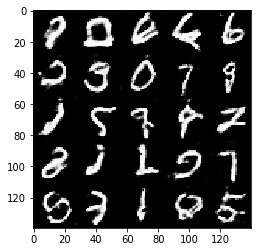

Epoch 2/2... Discriminator Loss: 0.5195... Generator Loss: 1.5897
Epoch 2/2... Discriminator Loss: 0.9484... Generator Loss: 0.7104
Epoch 2/2... Discriminator Loss: 0.6448... Generator Loss: 1.5248
Epoch 2/2... Discriminator Loss: 0.6743... Generator Loss: 1.3332
Epoch 2/2... Discriminator Loss: 2.2380... Generator Loss: 0.1618
Epoch 2/2... Discriminator Loss: 2.2051... Generator Loss: 4.4789
Epoch 2/2... Discriminator Loss: 0.9493... Generator Loss: 0.9075
Epoch 2/2... Discriminator Loss: 1.0541... Generator Loss: 0.6002
Epoch 2/2... Discriminator Loss: 0.6008... Generator Loss: 1.1550
Epoch 2/2... Discriminator Loss: 0.2634... Generator Loss: 2.0024


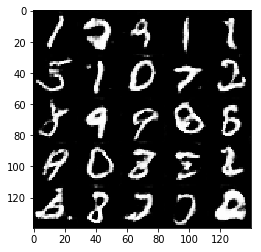

Epoch 2/2... Discriminator Loss: 0.6662... Generator Loss: 1.1299
Epoch 2/2... Discriminator Loss: 1.0918... Generator Loss: 0.6330
Epoch 2/2... Discriminator Loss: 0.4229... Generator Loss: 1.4342
Epoch 2/2... Discriminator Loss: 0.6454... Generator Loss: 0.9949
Epoch 2/2... Discriminator Loss: 0.4630... Generator Loss: 1.4820
Epoch 2/2... Discriminator Loss: 0.8043... Generator Loss: 0.8288
Epoch 2/2... Discriminator Loss: 0.4488... Generator Loss: 1.4114
Epoch 2/2... Discriminator Loss: 1.2095... Generator Loss: 0.4718
Epoch 2/2... Discriminator Loss: 0.8184... Generator Loss: 0.8285
Epoch 2/2... Discriminator Loss: 0.2851... Generator Loss: 1.8384


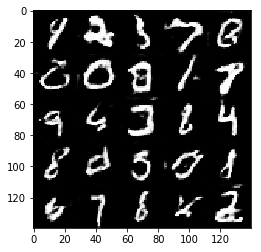

Epoch 2/2... Discriminator Loss: 0.3018... Generator Loss: 1.9190
Epoch 2/2... Discriminator Loss: 0.5924... Generator Loss: 1.0737
Epoch 2/2... Discriminator Loss: 0.8841... Generator Loss: 0.7725
Epoch 2/2... Discriminator Loss: 0.7106... Generator Loss: 0.9332
Epoch 2/2... Discriminator Loss: 1.4162... Generator Loss: 0.4705
Epoch 2/2... Discriminator Loss: 0.6250... Generator Loss: 1.0865
Epoch 2/2... Discriminator Loss: 0.3317... Generator Loss: 1.7424
Epoch 2/2... Discriminator Loss: 0.4824... Generator Loss: 1.4171
Epoch 2/2... Discriminator Loss: 0.4291... Generator Loss: 1.5139
Epoch 2/2... Discriminator Loss: 0.4613... Generator Loss: 1.5129


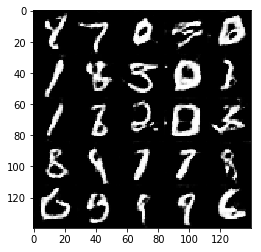

Epoch 2/2... Discriminator Loss: 0.1915... Generator Loss: 2.4570
Epoch 2/2... Discriminator Loss: 0.6560... Generator Loss: 0.9641
Epoch 2/2... Discriminator Loss: 1.1888... Generator Loss: 0.5328
Epoch 2/2... Discriminator Loss: 0.7439... Generator Loss: 0.8918
Epoch 2/2... Discriminator Loss: 0.5421... Generator Loss: 1.3497
Epoch 2/2... Discriminator Loss: 0.3895... Generator Loss: 1.5149
Epoch 2/2... Discriminator Loss: 0.2660... Generator Loss: 1.9814
Epoch 2/2... Discriminator Loss: 0.2058... Generator Loss: 2.0943
Epoch 2/2... Discriminator Loss: 0.3532... Generator Loss: 1.5495
Epoch 2/2... Discriminator Loss: 0.4097... Generator Loss: 1.4613


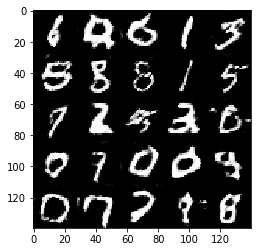

Epoch 2/2... Discriminator Loss: 0.6987... Generator Loss: 0.9872
Epoch 2/2... Discriminator Loss: 0.3239... Generator Loss: 1.5874
Epoch 2/2... Discriminator Loss: 0.1176... Generator Loss: 2.7466
Epoch 2/2... Discriminator Loss: 0.4194... Generator Loss: 1.4130
Epoch 2/2... Discriminator Loss: 0.1344... Generator Loss: 2.6225
Epoch 2/2... Discriminator Loss: 0.1447... Generator Loss: 2.4710
Epoch 2/2... Discriminator Loss: 0.5767... Generator Loss: 1.2508
Epoch 2/2... Discriminator Loss: 0.2788... Generator Loss: 2.2806
Epoch 2/2... Discriminator Loss: 0.3791... Generator Loss: 1.5235
Epoch 2/2... Discriminator Loss: 0.1123... Generator Loss: 2.8178


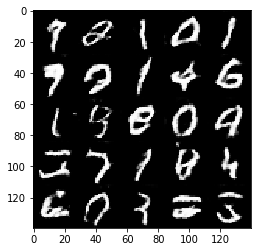

Epoch 2/2... Discriminator Loss: 0.2050... Generator Loss: 2.2590
Epoch 2/2... Discriminator Loss: 2.5950... Generator Loss: 0.2753
Epoch 2/2... Discriminator Loss: 0.3395... Generator Loss: 2.2974
Epoch 2/2... Discriminator Loss: 0.2722... Generator Loss: 3.0709
Epoch 2/2... Discriminator Loss: 0.6320... Generator Loss: 1.1877
Epoch 2/2... Discriminator Loss: 0.4080... Generator Loss: 2.9155
Epoch 2/2... Discriminator Loss: 1.6955... Generator Loss: 0.3389
Epoch 2/2... Discriminator Loss: 1.6189... Generator Loss: 0.7343
Epoch 2/2... Discriminator Loss: 0.9831... Generator Loss: 0.8161
Epoch 2/2... Discriminator Loss: 0.9086... Generator Loss: 3.8685


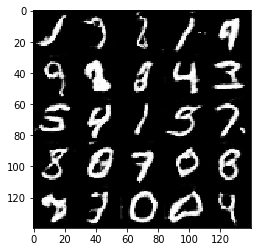

Epoch 2/2... Discriminator Loss: 0.5286... Generator Loss: 2.4640
Epoch 2/2... Discriminator Loss: 3.1039... Generator Loss: 0.0947
Epoch 2/2... Discriminator Loss: 0.9749... Generator Loss: 2.9347
Epoch 2/2... Discriminator Loss: 0.2816... Generator Loss: 3.2505
Epoch 2/2... Discriminator Loss: 1.6756... Generator Loss: 0.3541
Epoch 2/2... Discriminator Loss: 0.4733... Generator Loss: 1.2024
Epoch 2/2... Discriminator Loss: 0.3542... Generator Loss: 1.7611
Epoch 2/2... Discriminator Loss: 0.4753... Generator Loss: 1.5008
Epoch 2/2... Discriminator Loss: 0.6687... Generator Loss: 1.1624
Epoch 2/2... Discriminator Loss: 0.6376... Generator Loss: 0.9865


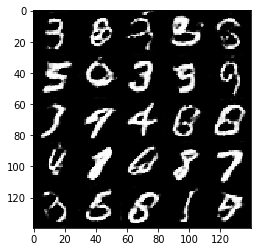

Epoch 2/2... Discriminator Loss: 1.4956... Generator Loss: 0.6147
Epoch 2/2... Discriminator Loss: 1.5153... Generator Loss: 4.6355
Epoch 2/2... Discriminator Loss: 0.5325... Generator Loss: 1.3183
Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 0.6332
Epoch 2/2... Discriminator Loss: 0.9038... Generator Loss: 0.7217
Epoch 2/2... Discriminator Loss: 0.7919... Generator Loss: 0.8528
Epoch 2/2... Discriminator Loss: 0.6185... Generator Loss: 1.0134
Epoch 2/2... Discriminator Loss: 0.4436... Generator Loss: 1.3755
Epoch 2/2... Discriminator Loss: 1.5611... Generator Loss: 0.4341
Epoch 2/2... Discriminator Loss: 1.2725... Generator Loss: 0.5362


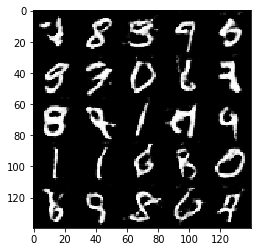

Epoch 2/2... Discriminator Loss: 0.9759... Generator Loss: 0.7554
Epoch 2/2... Discriminator Loss: 0.4329... Generator Loss: 3.4897
Epoch 2/2... Discriminator Loss: 2.2078... Generator Loss: 0.2225
Epoch 2/2... Discriminator Loss: 2.5983... Generator Loss: 0.1286
Epoch 2/2... Discriminator Loss: 1.8327... Generator Loss: 5.0036
Epoch 2/2... Discriminator Loss: 0.8047... Generator Loss: 0.9125
Epoch 2/2... Discriminator Loss: 0.4382... Generator Loss: 1.9070


In [12]:
batch_size = 32# as suggested by reviewer
z_dim = 100
learning_rate = 0.0005 # as suggested by reviewer
beta1 = 0.2 # as suggested by reviewer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0293... Generator Loss: 5.7067
Epoch 1/1... Discriminator Loss: 2.6616... Generator Loss: 21.7111
Epoch 1/1... Discriminator Loss: 0.9092... Generator Loss: 3.4968
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 1.4519
Epoch 1/1... Discriminator Loss: 2.0119... Generator Loss: 1.8993
Epoch 1/1... Discriminator Loss: 2.3205... Generator Loss: 2.4246
Epoch 1/1... Discriminator Loss: 2.0264... Generator Loss: 0.1949
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 3.1896
Epoch 1/1... Discriminator Loss: 1.9618... Generator Loss: 4.7441


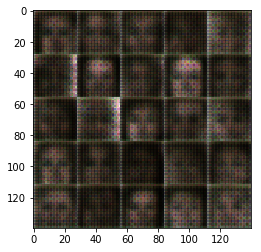

Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 2.9989... Generator Loss: 0.0607
Epoch 1/1... Discriminator Loss: 1.7175... Generator Loss: 0.2226
Epoch 1/1... Discriminator Loss: 1.6450... Generator Loss: 4.5637
Epoch 1/1... Discriminator Loss: 0.2049... Generator Loss: 4.1209
Epoch 1/1... Discriminator Loss: 0.7685... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 2.9006... Generator Loss: 0.0628
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 7.0387
Epoch 1/1... Discriminator Loss: 2.8423... Generator Loss: 5.6153


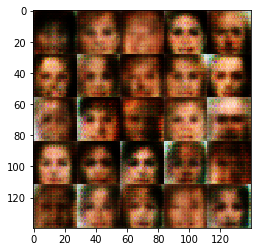

Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 5.0428
Epoch 1/1... Discriminator Loss: 0.6123... Generator Loss: 0.9702
Epoch 1/1... Discriminator Loss: 0.1460... Generator Loss: 5.8515
Epoch 1/1... Discriminator Loss: 2.1510... Generator Loss: 0.1704
Epoch 1/1... Discriminator Loss: 0.1959... Generator Loss: 5.3379
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 0.7411... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 0.6916... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.7178... Generator Loss: 0.2899
Epoch 1/1... Discriminator Loss: 0.3441... Generator Loss: 1.6625


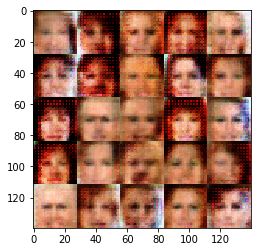

Epoch 1/1... Discriminator Loss: 0.0501... Generator Loss: 4.1747
Epoch 1/1... Discriminator Loss: 0.1078... Generator Loss: 2.9746
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 5.4376
Epoch 1/1... Discriminator Loss: 0.1294... Generator Loss: 2.5957
Epoch 1/1... Discriminator Loss: 0.0671... Generator Loss: 4.7545
Epoch 1/1... Discriminator Loss: 0.0469... Generator Loss: 4.2440
Epoch 1/1... Discriminator Loss: 0.0657... Generator Loss: 3.6711
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 0.4261... Generator Loss: 1.2912
Epoch 1/1... Discriminator Loss: 0.2512... Generator Loss: 3.7041


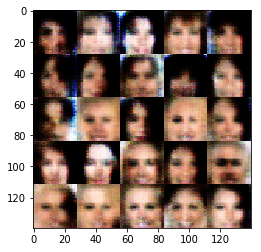

Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 3.1765
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 0.0734... Generator Loss: 3.2879
Epoch 1/1... Discriminator Loss: 0.1804... Generator Loss: 2.0504
Epoch 1/1... Discriminator Loss: 0.0428... Generator Loss: 4.4342
Epoch 1/1... Discriminator Loss: 1.7622... Generator Loss: 0.2538
Epoch 1/1... Discriminator Loss: 0.1785... Generator Loss: 3.1748
Epoch 1/1... Discriminator Loss: 0.6222... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 0.5072... Generator Loss: 1.3532
Epoch 1/1... Discriminator Loss: 0.7050... Generator Loss: 0.7844


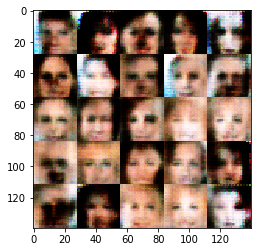

Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.4403
Epoch 1/1... Discriminator Loss: 0.1719... Generator Loss: 2.1187
Epoch 1/1... Discriminator Loss: 0.1200... Generator Loss: 4.2306
Epoch 1/1... Discriminator Loss: 0.2929... Generator Loss: 1.6814
Epoch 1/1... Discriminator Loss: 0.0382... Generator Loss: 6.4637
Epoch 1/1... Discriminator Loss: 0.2601... Generator Loss: 2.3811
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.4239
Epoch 1/1... Discriminator Loss: 0.0906... Generator Loss: 3.1905
Epoch 1/1... Discriminator Loss: 0.3255... Generator Loss: 1.9611
Epoch 1/1... Discriminator Loss: 1.5598... Generator Loss: 2.0571


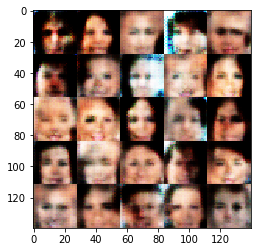

Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 0.2509... Generator Loss: 2.9125
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.3768
Epoch 1/1... Discriminator Loss: 0.1052... Generator Loss: 3.9349
Epoch 1/1... Discriminator Loss: 0.1978... Generator Loss: 2.0246
Epoch 1/1... Discriminator Loss: 0.1192... Generator Loss: 2.7776
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 0.0902... Generator Loss: 3.1686
Epoch 1/1... Discriminator Loss: 0.0643... Generator Loss: 3.7180
Epoch 1/1... Discriminator Loss: 2.9380... Generator Loss: 5.3060


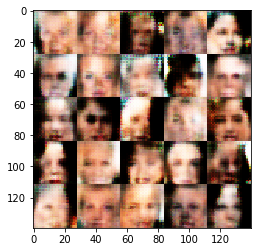

Epoch 1/1... Discriminator Loss: 0.0503... Generator Loss: 4.5752
Epoch 1/1... Discriminator Loss: 0.0380... Generator Loss: 5.3600
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 0.2172... Generator Loss: 3.1266
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 1.4720
Epoch 1/1... Discriminator Loss: 0.3594... Generator Loss: 1.6056
Epoch 1/1... Discriminator Loss: 0.1089... Generator Loss: 2.4877
Epoch 1/1... Discriminator Loss: 0.0814... Generator Loss: 3.3228
Epoch 1/1... Discriminator Loss: 0.0433... Generator Loss: 5.0497
Epoch 1/1... Discriminator Loss: 0.0311... Generator Loss: 4.0052


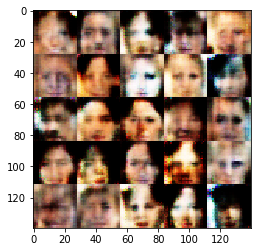

Epoch 1/1... Discriminator Loss: 0.0277... Generator Loss: 5.2192
Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 0.5204... Generator Loss: 1.1553
Epoch 1/1... Discriminator Loss: 0.2218... Generator Loss: 1.9232
Epoch 1/1... Discriminator Loss: 0.5647... Generator Loss: 1.7467
Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 4.6306
Epoch 1/1... Discriminator Loss: 0.0968... Generator Loss: 3.5290
Epoch 1/1... Discriminator Loss: 0.0565... Generator Loss: 4.5685
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 3.7247
Epoch 1/1... Discriminator Loss: 0.4774... Generator Loss: 1.5835


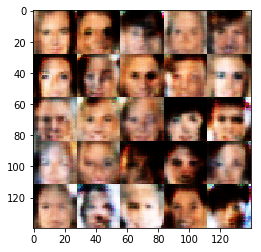

Epoch 1/1... Discriminator Loss: 0.0519... Generator Loss: 3.7644
Epoch 1/1... Discriminator Loss: 0.5240... Generator Loss: 2.2855
Epoch 1/1... Discriminator Loss: 0.1218... Generator Loss: 3.2038
Epoch 1/1... Discriminator Loss: 0.2656... Generator Loss: 6.5389
Epoch 1/1... Discriminator Loss: 0.0403... Generator Loss: 4.3080
Epoch 1/1... Discriminator Loss: 0.1355... Generator Loss: 2.6591
Epoch 1/1... Discriminator Loss: 0.3343... Generator Loss: 1.5154
Epoch 1/1... Discriminator Loss: 0.0427... Generator Loss: 3.6508
Epoch 1/1... Discriminator Loss: 0.0627... Generator Loss: 3.4124
Epoch 1/1... Discriminator Loss: 0.0242... Generator Loss: 4.7415


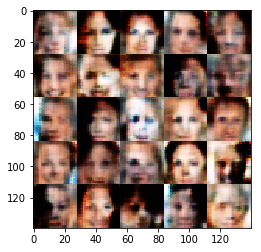

Epoch 1/1... Discriminator Loss: 2.1722... Generator Loss: 0.2475
Epoch 1/1... Discriminator Loss: 0.2995... Generator Loss: 2.3700
Epoch 1/1... Discriminator Loss: 0.2734... Generator Loss: 3.1720
Epoch 1/1... Discriminator Loss: 0.2266... Generator Loss: 1.7466
Epoch 1/1... Discriminator Loss: 0.1375... Generator Loss: 5.5849
Epoch 1/1... Discriminator Loss: 3.2779... Generator Loss: 5.4270
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 0.1559... Generator Loss: 3.3165
Epoch 1/1... Discriminator Loss: 0.2469... Generator Loss: 5.6202
Epoch 1/1... Discriminator Loss: 0.0892... Generator Loss: 5.4837


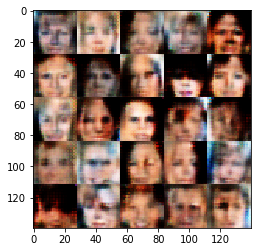

Epoch 1/1... Discriminator Loss: 0.0297... Generator Loss: 6.0475
Epoch 1/1... Discriminator Loss: 0.0332... Generator Loss: 4.5659
Epoch 1/1... Discriminator Loss: 0.0281... Generator Loss: 5.4902
Epoch 1/1... Discriminator Loss: 3.1077... Generator Loss: 6.3251
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 2.1928
Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 1.2846
Epoch 1/1... Discriminator Loss: 3.2785... Generator Loss: 4.3258
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.6857


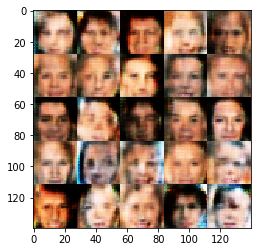

Epoch 1/1... Discriminator Loss: 0.7956... Generator Loss: 1.8074
Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 0.4977... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 0.2988... Generator Loss: 3.7213
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.4692
Epoch 1/1... Discriminator Loss: 0.1726... Generator Loss: 2.4460
Epoch 1/1... Discriminator Loss: 0.6725... Generator Loss: 1.0634
Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 4.3340
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 2.3565


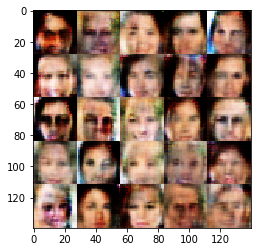

Epoch 1/1... Discriminator Loss: 3.5979... Generator Loss: 4.8910
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.5188
Epoch 1/1... Discriminator Loss: 0.0901... Generator Loss: 3.6807
Epoch 1/1... Discriminator Loss: 0.1660... Generator Loss: 2.2115
Epoch 1/1... Discriminator Loss: 0.0473... Generator Loss: 3.6589
Epoch 1/1... Discriminator Loss: 0.0647... Generator Loss: 3.3543
Epoch 1/1... Discriminator Loss: 0.0175... Generator Loss: 6.0222
Epoch 1/1... Discriminator Loss: 0.7516... Generator Loss: 2.9306
Epoch 1/1... Discriminator Loss: 0.7318... Generator Loss: 2.5251
Epoch 1/1... Discriminator Loss: 0.0528... Generator Loss: 3.9838


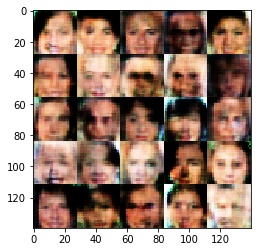

Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 0.0395... Generator Loss: 6.5607
Epoch 1/1... Discriminator Loss: 0.1656... Generator Loss: 2.2786
Epoch 1/1... Discriminator Loss: 0.0402... Generator Loss: 7.0741
Epoch 1/1... Discriminator Loss: 0.0224... Generator Loss: 4.7606
Epoch 1/1... Discriminator Loss: 0.0127... Generator Loss: 5.5409
Epoch 1/1... Discriminator Loss: 0.0109... Generator Loss: 5.7292
Epoch 1/1... Discriminator Loss: 0.2428... Generator Loss: 7.2264
Epoch 1/1... Discriminator Loss: 0.4596... Generator Loss: 1.5523
Epoch 1/1... Discriminator Loss: 0.7828... Generator Loss: 2.8785


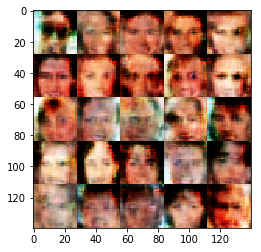

Epoch 1/1... Discriminator Loss: 0.7213... Generator Loss: 3.5407
Epoch 1/1... Discriminator Loss: 0.7760... Generator Loss: 0.9310
Epoch 1/1... Discriminator Loss: 0.5877... Generator Loss: 2.0237
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 0.7574... Generator Loss: 3.3496
Epoch 1/1... Discriminator Loss: 0.0475... Generator Loss: 3.9956
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 0.3905... Generator Loss: 2.3529
Epoch 1/1... Discriminator Loss: 0.3586... Generator Loss: 1.8436
Epoch 1/1... Discriminator Loss: 0.5355... Generator Loss: 1.3634


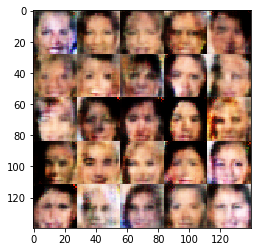

Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 1.8905
Epoch 1/1... Discriminator Loss: 0.3863... Generator Loss: 4.0620
Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 0.0361... Generator Loss: 3.7961
Epoch 1/1... Discriminator Loss: 0.0458... Generator Loss: 4.3468
Epoch 1/1... Discriminator Loss: 0.0190... Generator Loss: 4.8988
Epoch 1/1... Discriminator Loss: 0.1393... Generator Loss: 2.3687
Epoch 1/1... Discriminator Loss: 0.1790... Generator Loss: 2.2539
Epoch 1/1... Discriminator Loss: 0.2872... Generator Loss: 2.4223
Epoch 1/1... Discriminator Loss: 0.0211... Generator Loss: 5.4157


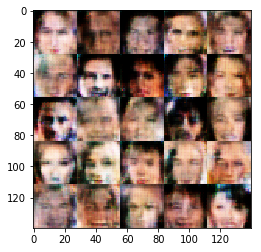

Epoch 1/1... Discriminator Loss: 2.1373... Generator Loss: 1.2741
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.3753
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.3880
Epoch 1/1... Discriminator Loss: 1.7509... Generator Loss: 4.0169
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 2.5378
Epoch 1/1... Discriminator Loss: 0.4631... Generator Loss: 1.4625
Epoch 1/1... Discriminator Loss: 0.2276... Generator Loss: 2.4897
Epoch 1/1... Discriminator Loss: 4.1780... Generator Loss: 4.7514


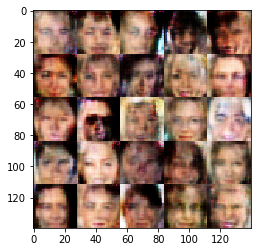

Epoch 1/1... Discriminator Loss: 0.3076... Generator Loss: 1.5609
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 2.2587
Epoch 1/1... Discriminator Loss: 0.6594... Generator Loss: 1.0739
Epoch 1/1... Discriminator Loss: 0.1799... Generator Loss: 2.2136
Epoch 1/1... Discriminator Loss: 0.0906... Generator Loss: 3.0555
Epoch 1/1... Discriminator Loss: 0.5623... Generator Loss: 1.6180
Epoch 1/1... Discriminator Loss: 0.7240... Generator Loss: 3.1311
Epoch 1/1... Discriminator Loss: 0.0612... Generator Loss: 4.0813
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 0.2839... Generator Loss: 3.0135


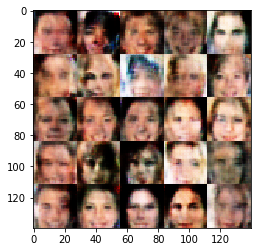

Epoch 1/1... Discriminator Loss: 0.0648... Generator Loss: 3.2674
Epoch 1/1... Discriminator Loss: 0.0994... Generator Loss: 2.7523
Epoch 1/1... Discriminator Loss: 0.7232... Generator Loss: 1.9138
Epoch 1/1... Discriminator Loss: 0.5407... Generator Loss: 1.6353
Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 0.0962... Generator Loss: 3.5739
Epoch 1/1... Discriminator Loss: 0.0629... Generator Loss: 3.5033
Epoch 1/1... Discriminator Loss: 0.0427... Generator Loss: 3.7891
Epoch 1/1... Discriminator Loss: 0.0329... Generator Loss: 4.3983
Epoch 1/1... Discriminator Loss: 0.0218... Generator Loss: 4.9838


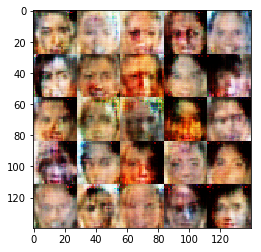

Epoch 1/1... Discriminator Loss: 0.1481... Generator Loss: 3.8261
Epoch 1/1... Discriminator Loss: 0.0083... Generator Loss: 6.4622
Epoch 1/1... Discriminator Loss: 0.0382... Generator Loss: 3.6473
Epoch 1/1... Discriminator Loss: 0.0634... Generator Loss: 3.1066
Epoch 1/1... Discriminator Loss: 0.0194... Generator Loss: 5.0909
Epoch 1/1... Discriminator Loss: 0.0152... Generator Loss: 5.8041
Epoch 1/1... Discriminator Loss: 0.0128... Generator Loss: 6.1839
Epoch 1/1... Discriminator Loss: 0.0379... Generator Loss: 3.6932
Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 2.0298
Epoch 1/1... Discriminator Loss: 0.5869... Generator Loss: 2.3219


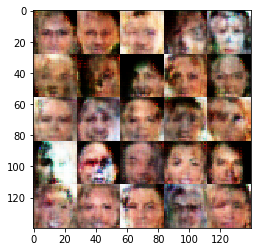

Epoch 1/1... Discriminator Loss: 0.3178... Generator Loss: 4.1634
Epoch 1/1... Discriminator Loss: 0.7571... Generator Loss: 2.8856
Epoch 1/1... Discriminator Loss: 0.0304... Generator Loss: 4.6350
Epoch 1/1... Discriminator Loss: 0.0220... Generator Loss: 5.2648
Epoch 1/1... Discriminator Loss: 0.0112... Generator Loss: 5.8972
Epoch 1/1... Discriminator Loss: 0.0190... Generator Loss: 4.8490
Epoch 1/1... Discriminator Loss: 0.0095... Generator Loss: 6.4269
Epoch 1/1... Discriminator Loss: 0.0083... Generator Loss: 5.6596
Epoch 1/1... Discriminator Loss: 0.0515... Generator Loss: 3.7314
Epoch 1/1... Discriminator Loss: 0.0111... Generator Loss: 6.1071


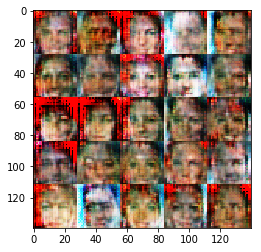

Epoch 1/1... Discriminator Loss: 0.0058... Generator Loss: 7.4669
Epoch 1/1... Discriminator Loss: 0.0351... Generator Loss: 3.8812
Epoch 1/1... Discriminator Loss: 0.0109... Generator Loss: 6.2140
Epoch 1/1... Discriminator Loss: 0.0393... Generator Loss: 6.0163
Epoch 1/1... Discriminator Loss: 0.5751... Generator Loss: 1.5927
Epoch 1/1... Discriminator Loss: 0.1076... Generator Loss: 3.2586
Epoch 1/1... Discriminator Loss: 0.1174... Generator Loss: 2.8734
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 1.4587
Epoch 1/1... Discriminator Loss: 0.7921... Generator Loss: 1.2991
Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 0.9958


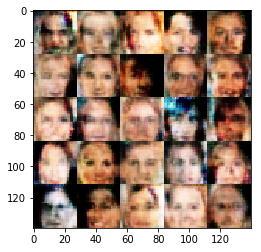

Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 1.0587
Epoch 1/1... Discriminator Loss: 2.2896... Generator Loss: 3.9056
Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 1.3019
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 3.8942
Epoch 1/1... Discriminator Loss: 0.7459... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 3.8312
Epoch 1/1... Discriminator Loss: 0.8043... Generator Loss: 1.9737
Epoch 1/1... Discriminator Loss: 0.7213... Generator Loss: 2.2627
Epoch 1/1... Discriminator Loss: 0.5888... Generator Loss: 2.1524


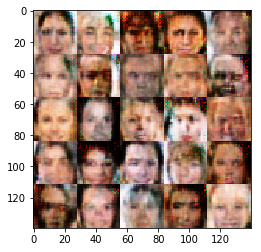

Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 0.9149... Generator Loss: 1.2656
Epoch 1/1... Discriminator Loss: 0.4379... Generator Loss: 1.5875
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.4191
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 2.2228... Generator Loss: 3.2787
Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 1.1104
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 2.6463
Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.2898
Epoch 1/1... Discriminator Loss: 4.4568... Generator Loss: 0.0280


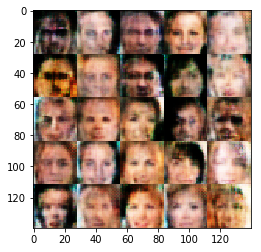

Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 1.2037
Epoch 1/1... Discriminator Loss: 0.3773... Generator Loss: 1.6297
Epoch 1/1... Discriminator Loss: 1.6862... Generator Loss: 0.3777
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 1.0475
Epoch 1/1... Discriminator Loss: 0.1664... Generator Loss: 3.0418
Epoch 1/1... Discriminator Loss: 0.1085... Generator Loss: 2.8879
Epoch 1/1... Discriminator Loss: 0.7479... Generator Loss: 0.7972


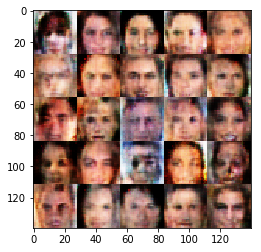

Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 0.5709
Epoch 1/1... Discriminator Loss: 0.1477... Generator Loss: 2.3427
Epoch 1/1... Discriminator Loss: 0.2036... Generator Loss: 4.1694
Epoch 1/1... Discriminator Loss: 0.1405... Generator Loss: 4.0230
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.5536
Epoch 1/1... Discriminator Loss: 0.0753... Generator Loss: 3.1575
Epoch 1/1... Discriminator Loss: 0.0294... Generator Loss: 4.3987
Epoch 1/1... Discriminator Loss: 3.3835... Generator Loss: 0.0439
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 2.1107
Epoch 1/1... Discriminator Loss: 0.7575... Generator Loss: 0.9854


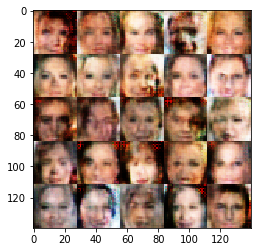

Epoch 1/1... Discriminator Loss: 1.6499... Generator Loss: 2.7674
Epoch 1/1... Discriminator Loss: 2.1302... Generator Loss: 0.1664
Epoch 1/1... Discriminator Loss: 0.2994... Generator Loss: 1.8080
Epoch 1/1... Discriminator Loss: 0.1546... Generator Loss: 2.1562
Epoch 1/1... Discriminator Loss: 0.2298... Generator Loss: 2.5887
Epoch 1/1... Discriminator Loss: 0.2959... Generator Loss: 1.7466
Epoch 1/1... Discriminator Loss: 4.6158... Generator Loss: 5.5306
Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 0.0976... Generator Loss: 3.0775
Epoch 1/1... Discriminator Loss: 3.2528... Generator Loss: 5.4537


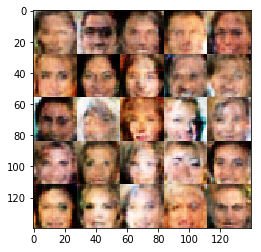

Epoch 1/1... Discriminator Loss: 0.0400... Generator Loss: 4.6528
Epoch 1/1... Discriminator Loss: 0.0649... Generator Loss: 3.4986
Epoch 1/1... Discriminator Loss: 0.0457... Generator Loss: 3.3896
Epoch 1/1... Discriminator Loss: 0.0827... Generator Loss: 2.7997
Epoch 1/1... Discriminator Loss: 0.6673... Generator Loss: 1.0010
Epoch 1/1... Discriminator Loss: 0.2610... Generator Loss: 3.0573
Epoch 1/1... Discriminator Loss: 0.0839... Generator Loss: 4.2728
Epoch 1/1... Discriminator Loss: 0.4422... Generator Loss: 5.1964
Epoch 1/1... Discriminator Loss: 0.0209... Generator Loss: 4.4355
Epoch 1/1... Discriminator Loss: 0.0127... Generator Loss: 5.3703


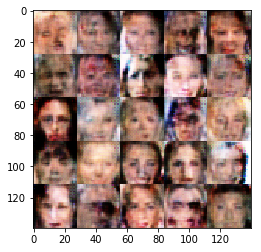

Epoch 1/1... Discriminator Loss: 0.0294... Generator Loss: 5.9269
Epoch 1/1... Discriminator Loss: 0.0260... Generator Loss: 4.1139
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 2.7861
Epoch 1/1... Discriminator Loss: 0.0395... Generator Loss: 3.8530
Epoch 1/1... Discriminator Loss: 0.0254... Generator Loss: 4.6661
Epoch 1/1... Discriminator Loss: 3.6471... Generator Loss: 0.0324
Epoch 1/1... Discriminator Loss: 2.2779... Generator Loss: 5.2178
Epoch 1/1... Discriminator Loss: 0.1373... Generator Loss: 2.8387
Epoch 1/1... Discriminator Loss: 0.0473... Generator Loss: 3.8756
Epoch 1/1... Discriminator Loss: 0.2781... Generator Loss: 2.7324


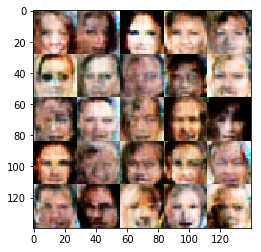

Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 1.6598
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 1.1437
Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 0.7248... Generator Loss: 1.4059
Epoch 1/1... Discriminator Loss: 0.5932... Generator Loss: 1.8959
Epoch 1/1... Discriminator Loss: 0.6980... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 0.3678... Generator Loss: 1.3757
Epoch 1/1... Discriminator Loss: 0.9119... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 0.3141... Generator Loss: 1.5373
Epoch 1/1... Discriminator Loss: 0.0497... Generator Loss: 3.6321


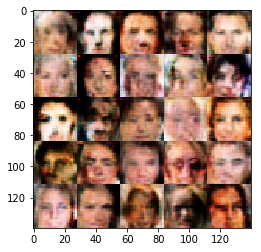

Epoch 1/1... Discriminator Loss: 0.1007... Generator Loss: 4.0842
Epoch 1/1... Discriminator Loss: 0.0229... Generator Loss: 4.6617
Epoch 1/1... Discriminator Loss: 0.0291... Generator Loss: 4.6128
Epoch 1/1... Discriminator Loss: 0.1740... Generator Loss: 6.4309
Epoch 1/1... Discriminator Loss: 0.0094... Generator Loss: 5.4489
Epoch 1/1... Discriminator Loss: 4.2415... Generator Loss: 0.0186
Epoch 1/1... Discriminator Loss: 0.4280... Generator Loss: 2.4869
Epoch 1/1... Discriminator Loss: 0.0871... Generator Loss: 2.8043
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 1.3683


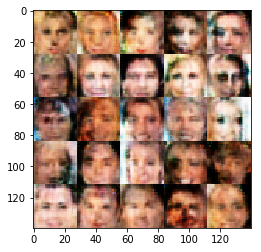

Epoch 1/1... Discriminator Loss: 0.6892... Generator Loss: 3.0155
Epoch 1/1... Discriminator Loss: 0.0886... Generator Loss: 3.0400
Epoch 1/1... Discriminator Loss: 0.0788... Generator Loss: 3.3610
Epoch 1/1... Discriminator Loss: 0.0529... Generator Loss: 3.7600
Epoch 1/1... Discriminator Loss: 0.6535... Generator Loss: 6.6821
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 1.1990
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 3.0520
Epoch 1/1... Discriminator Loss: 0.6098... Generator Loss: 1.2473
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 0.7085... Generator Loss: 0.9472


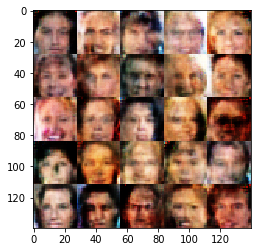

Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 2.5462
Epoch 1/1... Discriminator Loss: 0.0884... Generator Loss: 3.2365
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.4370
Epoch 1/1... Discriminator Loss: 0.0717... Generator Loss: 4.2874
Epoch 1/1... Discriminator Loss: 0.1966... Generator Loss: 2.0004
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.5545
Epoch 1/1... Discriminator Loss: 0.6610... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 0.1444... Generator Loss: 4.9054
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 1.4980
Epoch 1/1... Discriminator Loss: 1.7761... Generator Loss: 2.8462


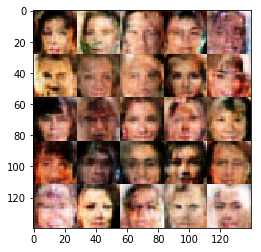

Epoch 1/1... Discriminator Loss: 0.0703... Generator Loss: 4.2486
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 0.0586... Generator Loss: 3.6342
Epoch 1/1... Discriminator Loss: 0.6849... Generator Loss: 2.6833
Epoch 1/1... Discriminator Loss: 0.0643... Generator Loss: 3.3514
Epoch 1/1... Discriminator Loss: 0.0445... Generator Loss: 4.0597
Epoch 1/1... Discriminator Loss: 0.2515... Generator Loss: 1.7192
Epoch 1/1... Discriminator Loss: 0.2374... Generator Loss: 1.8074
Epoch 1/1... Discriminator Loss: 0.0371... Generator Loss: 4.8792
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 2.6339


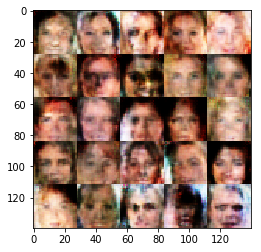

Epoch 1/1... Discriminator Loss: 0.1005... Generator Loss: 4.3770
Epoch 1/1... Discriminator Loss: 0.0643... Generator Loss: 3.4056
Epoch 1/1... Discriminator Loss: 0.0536... Generator Loss: 3.7538
Epoch 1/1... Discriminator Loss: 0.0279... Generator Loss: 5.1344
Epoch 1/1... Discriminator Loss: 0.0187... Generator Loss: 5.2150
Epoch 1/1... Discriminator Loss: 0.0718... Generator Loss: 4.8370
Epoch 1/1... Discriminator Loss: 0.0280... Generator Loss: 4.1412
Epoch 1/1... Discriminator Loss: 2.4409... Generator Loss: 0.1421
Epoch 1/1... Discriminator Loss: 0.7042... Generator Loss: 1.4784
Epoch 1/1... Discriminator Loss: 0.4722... Generator Loss: 2.6845


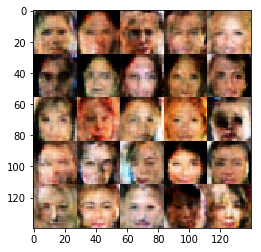

Epoch 1/1... Discriminator Loss: 0.1849... Generator Loss: 3.5015
Epoch 1/1... Discriminator Loss: 0.1899... Generator Loss: 2.1188
Epoch 1/1... Discriminator Loss: 6.3243... Generator Loss: 6.2623
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 2.5424
Epoch 1/1... Discriminator Loss: 0.1952... Generator Loss: 2.4042
Epoch 1/1... Discriminator Loss: 0.0876... Generator Loss: 4.5963
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.3409
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 2.7531
Epoch 1/1... Discriminator Loss: 0.1170... Generator Loss: 3.3659
Epoch 1/1... Discriminator Loss: 0.0283... Generator Loss: 4.3256


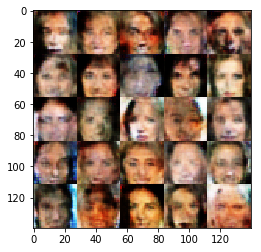

Epoch 1/1... Discriminator Loss: 0.4874... Generator Loss: 4.1276
Epoch 1/1... Discriminator Loss: 0.0129... Generator Loss: 5.4573
Epoch 1/1... Discriminator Loss: 0.0253... Generator Loss: 4.5033
Epoch 1/1... Discriminator Loss: 0.1867... Generator Loss: 5.9777
Epoch 1/1... Discriminator Loss: 0.0606... Generator Loss: 3.3204
Epoch 1/1... Discriminator Loss: 0.0189... Generator Loss: 5.0324
Epoch 1/1... Discriminator Loss: 0.0126... Generator Loss: 5.3941
Epoch 1/1... Discriminator Loss: 0.0156... Generator Loss: 6.7936
Epoch 1/1... Discriminator Loss: 0.0106... Generator Loss: 6.1386
Epoch 1/1... Discriminator Loss: 0.0170... Generator Loss: 5.2144


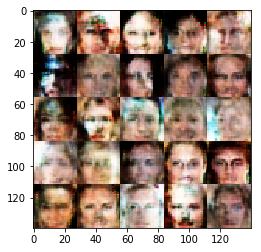

Epoch 1/1... Discriminator Loss: 2.0724... Generator Loss: 0.3201
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.1140
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 1.9814
Epoch 1/1... Discriminator Loss: 0.8490... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 0.4047... Generator Loss: 1.3379
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.4225
Epoch 1/1... Discriminator Loss: 0.0588... Generator Loss: 4.4556
Epoch 1/1... Discriminator Loss: 0.2182... Generator Loss: 4.6888
Epoch 1/1... Discriminator Loss: 2.7571... Generator Loss: 3.8267
Epoch 1/1... Discriminator Loss: 0.1554... Generator Loss: 3.2474


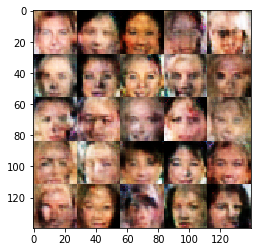

Epoch 1/1... Discriminator Loss: 0.0717... Generator Loss: 4.0237
Epoch 1/1... Discriminator Loss: 0.0983... Generator Loss: 2.9075
Epoch 1/1... Discriminator Loss: 0.0248... Generator Loss: 4.6503
Epoch 1/1... Discriminator Loss: 0.0259... Generator Loss: 4.4774
Epoch 1/1... Discriminator Loss: 0.0187... Generator Loss: 4.2939
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 2.2013
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 1.2921
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 2.9932
Epoch 1/1... Discriminator Loss: 2.7364... Generator Loss: 0.0987
Epoch 1/1... Discriminator Loss: 0.3385... Generator Loss: 3.7682


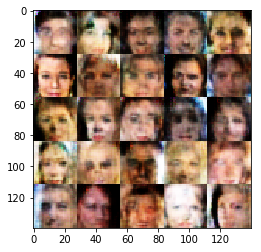

Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 3.1682
Epoch 1/1... Discriminator Loss: 0.4321... Generator Loss: 3.2484
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 0.1355... Generator Loss: 5.1684
Epoch 1/1... Discriminator Loss: 0.0264... Generator Loss: 4.9588
Epoch 1/1... Discriminator Loss: 0.2225... Generator Loss: 2.2009
Epoch 1/1... Discriminator Loss: 0.1436... Generator Loss: 6.3477
Epoch 1/1... Discriminator Loss: 0.0715... Generator Loss: 3.0623
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 0.5689... Generator Loss: 2.4992


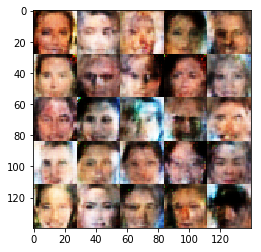

Epoch 1/1... Discriminator Loss: 0.7904... Generator Loss: 1.8125
Epoch 1/1... Discriminator Loss: 1.9514... Generator Loss: 3.5931
Epoch 1/1... Discriminator Loss: 0.0658... Generator Loss: 3.4163
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.3720
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 2.4869
Epoch 1/1... Discriminator Loss: 0.4409... Generator Loss: 1.8360
Epoch 1/1... Discriminator Loss: 0.6256... Generator Loss: 1.5259
Epoch 1/1... Discriminator Loss: 1.9057... Generator Loss: 0.2204
Epoch 1/1... Discriminator Loss: 0.8749... Generator Loss: 1.2482
Epoch 1/1... Discriminator Loss: 2.2650... Generator Loss: 0.1673


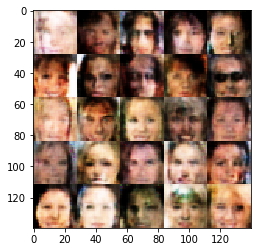

Epoch 1/1... Discriminator Loss: 0.3130... Generator Loss: 2.9208
Epoch 1/1... Discriminator Loss: 3.2834... Generator Loss: 6.3878
Epoch 1/1... Discriminator Loss: 0.0754... Generator Loss: 3.3052
Epoch 1/1... Discriminator Loss: 2.0041... Generator Loss: 2.9941
Epoch 1/1... Discriminator Loss: 0.7955... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.7143... Generator Loss: 3.4838
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.4589
Epoch 1/1... Discriminator Loss: 0.0863... Generator Loss: 3.2054
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 1.6705
Epoch 1/1... Discriminator Loss: 0.7347... Generator Loss: 1.0056


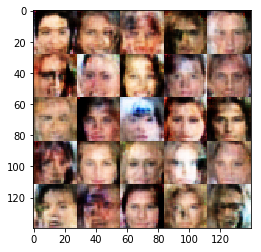

Epoch 1/1... Discriminator Loss: 1.8526... Generator Loss: 3.0924
Epoch 1/1... Discriminator Loss: 0.1696... Generator Loss: 2.5197
Epoch 1/1... Discriminator Loss: 0.1077... Generator Loss: 3.6692
Epoch 1/1... Discriminator Loss: 0.0459... Generator Loss: 3.6608
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 0.7376... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 0.7747... Generator Loss: 1.1168
Epoch 1/1... Discriminator Loss: 0.4175... Generator Loss: 2.1125
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 0.4999... Generator Loss: 1.5415


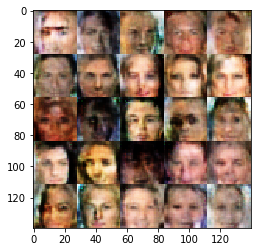

Epoch 1/1... Discriminator Loss: 0.3217... Generator Loss: 1.5874
Epoch 1/1... Discriminator Loss: 0.5528... Generator Loss: 1.3383
Epoch 1/1... Discriminator Loss: 0.2412... Generator Loss: 2.1164
Epoch 1/1... Discriminator Loss: 0.1552... Generator Loss: 2.1503
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.5435
Epoch 1/1... Discriminator Loss: 0.2542... Generator Loss: 2.1179
Epoch 1/1... Discriminator Loss: 0.0858... Generator Loss: 3.4041
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 0.7534


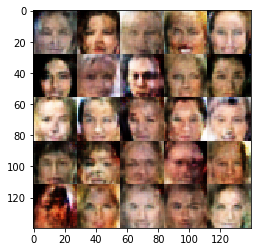

Epoch 1/1... Discriminator Loss: 0.0486... Generator Loss: 4.4168
Epoch 1/1... Discriminator Loss: 0.1560... Generator Loss: 2.2079
Epoch 1/1... Discriminator Loss: 0.0319... Generator Loss: 4.8012
Epoch 1/1... Discriminator Loss: 0.0390... Generator Loss: 5.0707
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 5.7655
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.4298
Epoch 1/1... Discriminator Loss: 0.7355... Generator Loss: 1.0611
Epoch 1/1... Discriminator Loss: 0.2789... Generator Loss: 2.2960
Epoch 1/1... Discriminator Loss: 0.0509... Generator Loss: 3.9406
Epoch 1/1... Discriminator Loss: 2.2363... Generator Loss: 0.1441


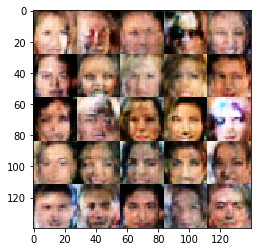

Epoch 1/1... Discriminator Loss: 0.0540... Generator Loss: 4.1167
Epoch 1/1... Discriminator Loss: 0.4769... Generator Loss: 5.9407
Epoch 1/1... Discriminator Loss: 2.2832... Generator Loss: 0.1655
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.4371
Epoch 1/1... Discriminator Loss: 0.5078... Generator Loss: 2.5494
Epoch 1/1... Discriminator Loss: 0.1451... Generator Loss: 2.4387
Epoch 1/1... Discriminator Loss: 2.3319... Generator Loss: 0.1500
Epoch 1/1... Discriminator Loss: 0.1614... Generator Loss: 3.8504
Epoch 1/1... Discriminator Loss: 0.0988... Generator Loss: 3.6004
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.7909


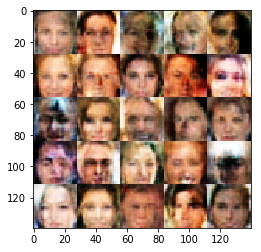

Epoch 1/1... Discriminator Loss: 0.0992... Generator Loss: 4.8751
Epoch 1/1... Discriminator Loss: 0.0270... Generator Loss: 4.7957
Epoch 1/1... Discriminator Loss: 0.0456... Generator Loss: 4.1002
Epoch 1/1... Discriminator Loss: 3.0500... Generator Loss: 0.0849
Epoch 1/1... Discriminator Loss: 0.0520... Generator Loss: 4.0571
Epoch 1/1... Discriminator Loss: 0.2257... Generator Loss: 1.8016
Epoch 1/1... Discriminator Loss: 0.1003... Generator Loss: 2.9798
Epoch 1/1... Discriminator Loss: 0.1085... Generator Loss: 5.7560
Epoch 1/1... Discriminator Loss: 0.2794... Generator Loss: 1.6063
Epoch 1/1... Discriminator Loss: 0.0950... Generator Loss: 7.0697


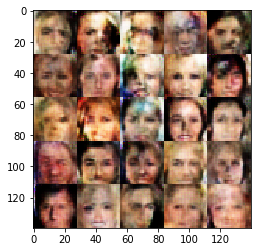

Epoch 1/1... Discriminator Loss: 0.7335... Generator Loss: 1.8781
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 0.3459... Generator Loss: 4.1554
Epoch 1/1... Discriminator Loss: 0.0264... Generator Loss: 4.9321
Epoch 1/1... Discriminator Loss: 0.0711... Generator Loss: 3.2977
Epoch 1/1... Discriminator Loss: 0.0351... Generator Loss: 4.0106
Epoch 1/1... Discriminator Loss: 0.0300... Generator Loss: 4.7412
Epoch 1/1... Discriminator Loss: 0.1631... Generator Loss: 2.3736
Epoch 1/1... Discriminator Loss: 0.0097... Generator Loss: 5.3285
Epoch 1/1... Discriminator Loss: 0.0401... Generator Loss: 4.0341


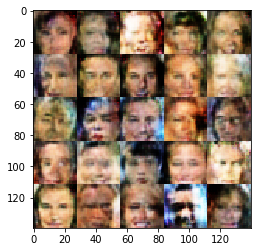

Epoch 1/1... Discriminator Loss: 0.0187... Generator Loss: 7.5494
Epoch 1/1... Discriminator Loss: 0.0210... Generator Loss: 6.1625
Epoch 1/1... Discriminator Loss: 0.0098... Generator Loss: 6.0584
Epoch 1/1... Discriminator Loss: 0.0193... Generator Loss: 5.3501
Epoch 1/1... Discriminator Loss: 0.0208... Generator Loss: 5.1347
Epoch 1/1... Discriminator Loss: 0.0379... Generator Loss: 3.8011
Epoch 1/1... Discriminator Loss: 0.0318... Generator Loss: 4.4229
Epoch 1/1... Discriminator Loss: 0.0120... Generator Loss: 5.5901
Epoch 1/1... Discriminator Loss: 1.5668... Generator Loss: 4.5379
Epoch 1/1... Discriminator Loss: 0.3975... Generator Loss: 1.8950


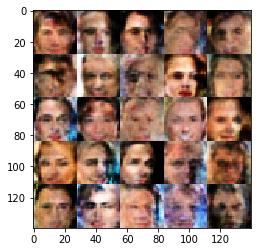

Epoch 1/1... Discriminator Loss: 0.5402... Generator Loss: 3.1198
Epoch 1/1... Discriminator Loss: 0.1156... Generator Loss: 2.9248
Epoch 1/1... Discriminator Loss: 0.3141... Generator Loss: 1.5966
Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 1.5722
Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 2.6381
Epoch 1/1... Discriminator Loss: 0.2253... Generator Loss: 1.8776
Epoch 1/1... Discriminator Loss: 0.2189... Generator Loss: 6.7094
Epoch 1/1... Discriminator Loss: 0.2558... Generator Loss: 1.9901
Epoch 1/1... Discriminator Loss: 0.0386... Generator Loss: 4.5475


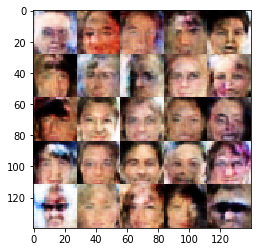

Epoch 1/1... Discriminator Loss: 0.0413... Generator Loss: 3.7317
Epoch 1/1... Discriminator Loss: 0.1424... Generator Loss: 2.2083
Epoch 1/1... Discriminator Loss: 0.0261... Generator Loss: 5.1405
Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 1.7845
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 2.0503
Epoch 1/1... Discriminator Loss: 0.7074... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.5295... Generator Loss: 2.8936
Epoch 1/1... Discriminator Loss: 0.8308... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 3.3859


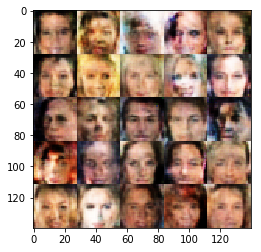

Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 0.4330... Generator Loss: 1.4134
Epoch 1/1... Discriminator Loss: 0.1325... Generator Loss: 2.6035
Epoch 1/1... Discriminator Loss: 0.0594... Generator Loss: 5.4805
Epoch 1/1... Discriminator Loss: 0.1018... Generator Loss: 2.7701
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 2.2705
Epoch 1/1... Discriminator Loss: 0.2297... Generator Loss: 1.8770
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.5085
Epoch 1/1... Discriminator Loss: 0.3300... Generator Loss: 1.8715


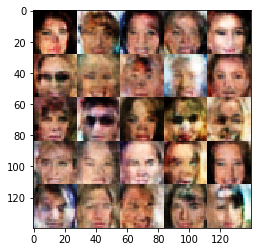

Epoch 1/1... Discriminator Loss: 0.3241... Generator Loss: 1.5210
Epoch 1/1... Discriminator Loss: 0.0715... Generator Loss: 3.9017
Epoch 1/1... Discriminator Loss: 3.9855... Generator Loss: 6.1520
Epoch 1/1... Discriminator Loss: 0.3516... Generator Loss: 2.2180
Epoch 1/1... Discriminator Loss: 0.3566... Generator Loss: 1.4713
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 0.0755... Generator Loss: 3.1053
Epoch 1/1... Discriminator Loss: 0.0594... Generator Loss: 4.3055
Epoch 1/1... Discriminator Loss: 0.0930... Generator Loss: 3.0920
Epoch 1/1... Discriminator Loss: 1.7556... Generator Loss: 0.4113


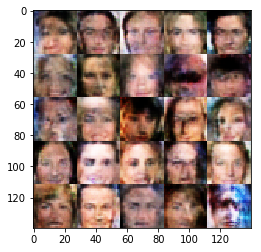

Epoch 1/1... Discriminator Loss: 0.7577... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.6879... Generator Loss: 0.3429
Epoch 1/1... Discriminator Loss: 0.7710... Generator Loss: 1.0856
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 1.9599... Generator Loss: 3.6150
Epoch 1/1... Discriminator Loss: 0.2134... Generator Loss: 2.9347
Epoch 1/1... Discriminator Loss: 5.0912... Generator Loss: 0.0090
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 1.0441
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 2.2108


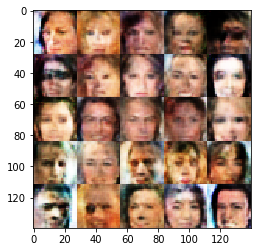

Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 1.2334
Epoch 1/1... Discriminator Loss: 0.9235... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 3.8499... Generator Loss: 5.3887
Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 0.2324... Generator Loss: 1.9438
Epoch 1/1... Discriminator Loss: 0.1832... Generator Loss: 3.0734
Epoch 1/1... Discriminator Loss: 0.0552... Generator Loss: 3.4839
Epoch 1/1... Discriminator Loss: 0.0930... Generator Loss: 3.5522
Epoch 1/1... Discriminator Loss: 0.1620... Generator Loss: 2.1702
Epoch 1/1... Discriminator Loss: 0.1213... Generator Loss: 2.5803


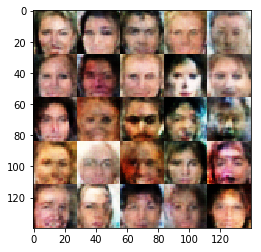

Epoch 1/1... Discriminator Loss: 0.0313... Generator Loss: 4.8024
Epoch 1/1... Discriminator Loss: 1.6813... Generator Loss: 0.3489
Epoch 1/1... Discriminator Loss: 2.0052... Generator Loss: 0.2089
Epoch 1/1... Discriminator Loss: 0.1963... Generator Loss: 2.1052
Epoch 1/1... Discriminator Loss: 0.1356... Generator Loss: 3.2780
Epoch 1/1... Discriminator Loss: 0.0700... Generator Loss: 3.8720
Epoch 1/1... Discriminator Loss: 0.7173... Generator Loss: 1.0914
Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 1.7889
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 2.5735


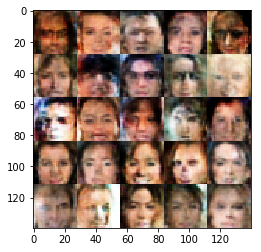

Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 2.1201
Epoch 1/1... Discriminator Loss: 0.5469... Generator Loss: 1.1420
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 1.4868
Epoch 1/1... Discriminator Loss: 0.7411... Generator Loss: 1.3220
Epoch 1/1... Discriminator Loss: 0.3843... Generator Loss: 1.6919
Epoch 1/1... Discriminator Loss: 0.1847... Generator Loss: 3.5879
Epoch 1/1... Discriminator Loss: 0.1246... Generator Loss: 5.5334
Epoch 1/1... Discriminator Loss: 0.1378... Generator Loss: 2.4408
Epoch 1/1... Discriminator Loss: 0.0587... Generator Loss: 3.6380
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 0.9165


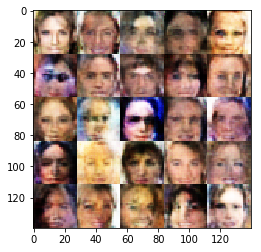

Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 2.0838... Generator Loss: 3.4196
Epoch 1/1... Discriminator Loss: 0.6388... Generator Loss: 3.0898
Epoch 1/1... Discriminator Loss: 0.0585... Generator Loss: 3.6406
Epoch 1/1... Discriminator Loss: 0.0564... Generator Loss: 5.3728
Epoch 1/1... Discriminator Loss: 0.0235... Generator Loss: 4.3210
Epoch 1/1... Discriminator Loss: 2.1906... Generator Loss: 3.2841
Epoch 1/1... Discriminator Loss: 0.0532... Generator Loss: 4.7911
Epoch 1/1... Discriminator Loss: 1.9687... Generator Loss: 4.1343
Epoch 1/1... Discriminator Loss: 0.0485... Generator Loss: 3.9287


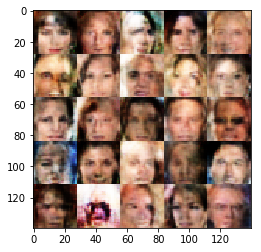

Epoch 1/1... Discriminator Loss: 0.0907... Generator Loss: 4.0671
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 0.0432... Generator Loss: 4.4516
Epoch 1/1... Discriminator Loss: 0.1521... Generator Loss: 2.4741
Epoch 1/1... Discriminator Loss: 0.0790... Generator Loss: 2.8894
Epoch 1/1... Discriminator Loss: 0.0622... Generator Loss: 3.5550
Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 0.5602... Generator Loss: 1.7431
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.4232
Epoch 1/1... Discriminator Loss: 0.6736... Generator Loss: 2.7774


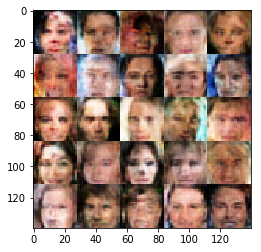

Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 2.7309
Epoch 1/1... Discriminator Loss: 0.2657... Generator Loss: 1.7179
Epoch 1/1... Discriminator Loss: 0.0632... Generator Loss: 3.3583
Epoch 1/1... Discriminator Loss: 0.0522... Generator Loss: 3.9200
Epoch 1/1... Discriminator Loss: 0.0375... Generator Loss: 4.5866
Epoch 1/1... Discriminator Loss: 0.0238... Generator Loss: 5.6844
Epoch 1/1... Discriminator Loss: 0.0332... Generator Loss: 5.3999
Epoch 1/1... Discriminator Loss: 0.0172... Generator Loss: 5.9801
Epoch 1/1... Discriminator Loss: 0.6882... Generator Loss: 1.1066
Epoch 1/1... Discriminator Loss: 0.6144... Generator Loss: 1.7114


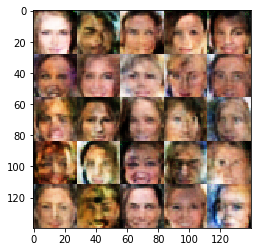

Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 0.0495... Generator Loss: 3.9154
Epoch 1/1... Discriminator Loss: 0.2288... Generator Loss: 4.7249
Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 1.4647
Epoch 1/1... Discriminator Loss: 0.6533... Generator Loss: 2.0720
Epoch 1/1... Discriminator Loss: 0.2495... Generator Loss: 2.0112
Epoch 1/1... Discriminator Loss: 0.1234... Generator Loss: 2.5644
Epoch 1/1... Discriminator Loss: 4.5294... Generator Loss: 5.3745
Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 0.5564
Epoch 1/1... Discriminator Loss: 0.6757... Generator Loss: 2.1926


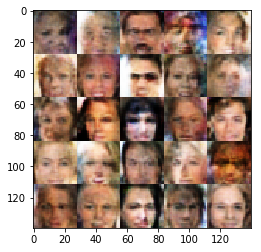

Epoch 1/1... Discriminator Loss: 0.6927... Generator Loss: 1.4039
Epoch 1/1... Discriminator Loss: 0.6335... Generator Loss: 3.3740
Epoch 1/1... Discriminator Loss: 0.1498... Generator Loss: 2.4276
Epoch 1/1... Discriminator Loss: 0.0674... Generator Loss: 3.2218
Epoch 1/1... Discriminator Loss: 0.4686... Generator Loss: 1.1696
Epoch 1/1... Discriminator Loss: 0.0400... Generator Loss: 4.5580
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 0.0697... Generator Loss: 3.2776
Epoch 1/1... Discriminator Loss: 0.0185... Generator Loss: 5.3110
Epoch 1/1... Discriminator Loss: 0.7836... Generator Loss: 0.9794


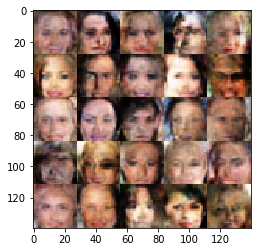

Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 4.3711
Epoch 1/1... Discriminator Loss: 0.2032... Generator Loss: 2.0552
Epoch 1/1... Discriminator Loss: 0.1462... Generator Loss: 5.1383


In [13]:
batch_size = 32 # as suggested by reviewer
z_dim = 100
learning_rate = 0.0005  # as suggested by reviewer
beta1 = 0.2 # as suggested by reviewer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.